# Inferred Number of Quantum Dots Using the Potential Landscape 

We will briefly look into how the number of quantum dots is inferred using 1D
cross-sections of the 2D electrostatic potential landscapes.

In [1]:
import os
from pathlib import Path
path = Path(os.getcwd())

# update base working directory to QuDiPy
if path.stem != 'QuDiPy':
    base_dir = path.parents[1]
    os.chdir(base_dir)
else:
    base_dir = path

## 0. Import relevant Python and QuDiPy modules

Import DotArray class which generates dot objects. Each dot array object requires
us to specify the expected number of quantum dots which will be used to detect 
dot merging events.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

from qudipy.system import DotArray

ModuleNotFoundError: No module named 'qudipy'

## 1. Generate Dots object instance

Refer to [2QD DotArray Usage Tutorial](./Dot%20Array%20Class%20Usage%202%20Dots.ipynb) for more about creating dots objects.

In [3]:
nav_dir = os.path.join('QuDiPy data', 'development')
processed_dir = os.path.join(base_dir, nav_dir,
                            'processed','2QD_processed')
nextnano_dir = os.path.join(base_dir, nav_dir,
                                    'nextnano','2QD_dotsep_60nm')
                
n_dots = 2      # anticipated number of dots

In [4]:
pts = [6,6,6]
ctrl_vals = [np.linspace(0.2, 0.45, pts[0]),
    np.linspace(-0.1, 0.15, pts[1]),
    np.linspace(0.2, 0.45, pts[2])]

file_prefix = 'resource'

### 1.2 Create object instance 

Here we are loading only the 2D electrostatic potentials to use potential interpolation
objects. These will be used to give an example for counting the number of dots is
performed. 

In [5]:
dots = DotArray(n_dots, ctrl_ranges=ctrl_vals, save=True, calc=False)
dots.numeric(processed_dir, nextnano_dir, file_prefix)

NameError: name 'DotArray' is not defined

We can reference the potential interpolators as follows.

In [6]:
ctrl_vector = [ 0.2, -0.1, 0.45]
dots.potential.plot(ctrl_vector, plot_type='1D', y_slice=0, show_wf=True)

NameError: name 'dots' is not defined

## 2. Counting Dots

### 2.1 Create a Pseudo Potential for an Example 

First create function that creates potential signal that is applied to a given 1D potential.
This is useful for testing the peak finding routine.

We will overlay "ripples" on top of the potential landscape to show the robustness 
of the dot finding routine. These ripples currently arise at the edges of the 
simulated dot systems due to boundary conditions and a non-linear rectilinear 
grid used when solving the Poisson PDE (the grid mesh typically is less dense 
at the boundaries).


In [7]:
def window(func, x, bounds):

    # define regions where to apply func
    x_left = x[x<bounds[0]]
    signal_left = func(x_left)

    x_right = x[bounds[1]<x]
    signal_right = func(x_right)

    # middle region is left untouched
    x_middle = np.squeeze(np.where((x>bounds[0]) & (bounds[1]>x)))
    signal_middle = np.zeros((len(x_middle)))

    # stack modified signals into new signal
    return np.hstack([signal_left, signal_middle, signal_right])

# define a test function which resembles "edge" effects for some simulated 
# electrostatic potential data
def fast_sin(x):
    return 1e-22*np.sin(x*5e8)

### 2.1 Find the Number or Local Maxima/Minima Defining dots

First we select a 1D potential slice from a 2D potential for a given voltage
configuration.

In [8]:
# get 1D potential slice
pot_1d = dots.potential(ctrl_vector)[70,:]

# get coordinates along slice
x_coords = dots.potential.x_coords

NameError: name 'dots' is not defined

Generate a signal of "false dots" near the boundaries of the simulated dot system.
False dots refer to erroneous minamas/maximas found which are used to infer the 
number of dots in the system.

In [9]:
bounds = [-0.6e-7, 0.6e-7]
false_dots = window(fast_sin, x_coords, bounds)

NameError: name 'x_coords' is not defined

Apply that signal to the original 1D potential slice.

In [10]:
pseudo_pot_slice = pot_1d+false_dots

NameError: name 'pot_1d' is not defined

Find the mean potential value for a given 1D potential slice. This is used to 
determine if a found local maxima/minima is associated to a dot or is erroneous.
The mean is used compared to the median to account for cases of larger dot 
systems which will shift the median towards the potential defining the dots more 
than the mean. This could lead to miss-counting number of local minima.

To make the counting routine more robust to <span style="color:red">*high bias potential regimes*</span> or <span style="color:red">*non-uniform mesh grids*</span>, a cut_off parameter is used.
Any potential minimum below the cut_off value is counted as a visible dot.

In [11]:
# create relevant variables to define the cutoff value
global_max = np.max(pseudo_pot_slice)
mean = np.mean(pseudo_pot_slice)
median = np.median(pseudo_pot_slice)

NameError: name 'pseudo_pot_slice' is not defined

Two methods for defining the cutoff value will be considered:

1) Using the mean of the 1D potential slice

In [12]:
# creating cut off from mid point between global max and mean of the potential
diff = abs(global_max - mean) * 0.5
cut_off_mean = global_max - diff

NameError: name 'global_max' is not defined

2) Using the median of the 1D potential slice

In [13]:
# creating cut off from mid point between global max and median of the potential
diff = abs(global_max - median) * 0.5
cut_off_median = global_max - diff

NameError: name 'global_max' is not defined

Let's plot the 1D potential and the histogram of a 1D potential slice.

NameError: name 'x_coords' is not defined

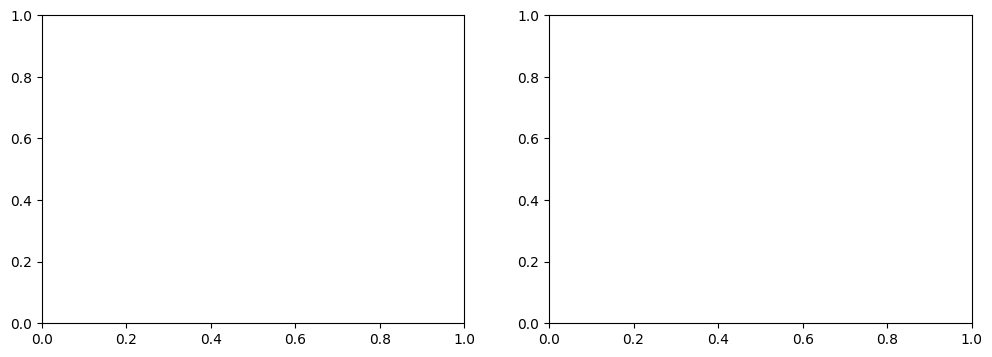

In [14]:
fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].plot(x_coords, pseudo_pot_slice, '.-k', markersize=4)
ax[0].plot([np.min(x_coords), np.max(x_coords)], [mean, mean], '-b', label = 'Mean')
ax[0].plot([np.min(x_coords), np.max(x_coords)], [cut_off_mean, cut_off_mean], '--b', label = 'Cut Off: Mean')
ax[0].plot([np.min(x_coords), np.max(x_coords)], [cut_off_median, cut_off_median], '--g', label = 'Cut Off: Median')
# plot median as an example
median = np.median(pseudo_pot_slice)
ax[0].plot([np.min(x_coords), np.max(x_coords)], [median, median], '-g', label = 'Median')

ax[0].set_ylabel('Potential [J]')
ax[0].set_xlabel('x-Coordinate [m]')
ax[0].legend(loc='upper center', ncol=2)

# plot historgram of potential values
ax[1].hist(pseudo_pot_slice, bins=25, orientation="horizontal")
ax[1].set_ylabel('Potential [J]')
ax[1].set_xlabel('Counts')

fig.suptitle('Synthetic 1D Dot Potential')

To find the number of dots, we count the number of non-erroneous minimas in the
1D potential. This is done by finding the minimas that are smaller than the mean/median/cutoff
of the 1D potential slice. 

The cutoff defined using the mean will be used as the default method.

In [15]:
minima = find_peaks((-1) * pseudo_pot_slice, height=-cut_off_mean)[0]

NameError: name 'pseudo_pot_slice' is not defined

For masking purposes, the local maxima between dots is determined. This is done 
by finding the local maxima between the outermost minima.

In [16]:
if len(minima)>1:
        x_eval_coord = x_coords[minima[0]:minima[-1]]
        bounded_pot = pseudo_pot_slice[minima[0]:minima[-1]]
        maxima = minima[0] + find_peaks(bounded_pot)[0]

NameError: name 'minima' is not defined

Finally, we see the local minima/maxima peaks found resulting from ignoring any 
minima that are not less than the cutoff. Erroneous dots are mimicked to left/right 
of the red vertical dashed lines.

NameError: name 'x_coords' is not defined

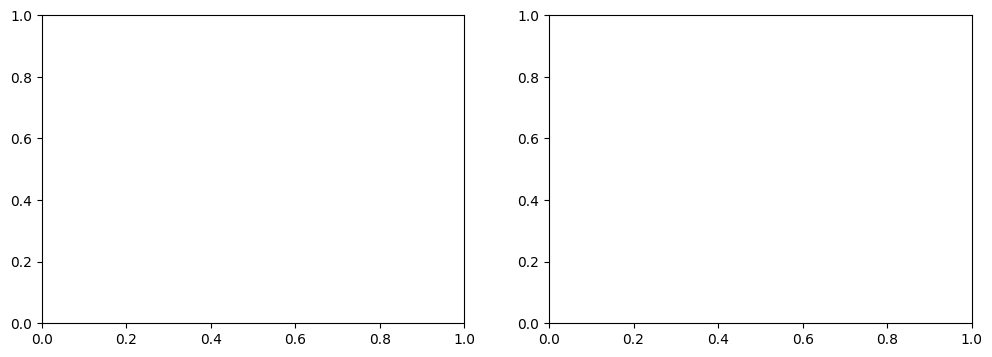

In [17]:
fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].plot(x_coords, pseudo_pot_slice, '.-k', markersize=4)
ax[0].plot([bounds[0], bounds[0]], [np.min(pseudo_pot_slice), np.max(pseudo_pot_slice)], '--r')
ax[0].plot([bounds[1], bounds[1]], [np.min(pseudo_pot_slice), np.max(pseudo_pot_slice)], '--r')
ax[0].plot([np.min(x_coords), np.max(x_coords)], [mean, mean], '-b', label = 'Mean')
ax[0].plot([np.min(x_coords), np.max(x_coords)], [cut_off_mean, cut_off_mean], '--b', label = 'Cut Off: Mean')
ax[0].plot([np.min(x_coords), np.max(x_coords)], [cut_off_median, cut_off_median], '--g', label = 'Cut Off: Median')
ax[0].scatter(x_coords[minima], pseudo_pot_slice[minima], color='r', marker='.', s=200, zorder=5)
ax[0].scatter(x_coords[maxima], pseudo_pot_slice[maxima], color='g', marker='.', s=200, zorder=5)
# plot median as an example
median = np.median(pseudo_pot_slice)
ax[0].plot([np.min(x_coords), np.max(x_coords)], [median, median], '-g', label = 'Median')

ax[0].set_ylabel('Potential [J]')
ax[0].set_xlabel('x-Coordinate [m]')
ax[0].legend(loc='upper center')

# plot historgram of potential values
ax[1].hist(pseudo_pot_slice, bins=25, orientation="horizontal")
ax[1].set_ylabel('Potential [J]')
ax[1].set_xlabel('Counts')

fig.suptitle('Synthetic 1D Dot Potential')